#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [35]:
!which python

Der Befehl "which" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# Install dependencies:

In [36]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

# Imports

In [37]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
#import umap
import umap.umap_ as umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

# Functions to Save and load manually

In [38]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [39]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [40]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [41]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [42]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [43]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.77886724
n_clusters: 102 silhouette_avg: 0.32017758
n_clusters: 202 silhouette_avg: 0.3242858
n_clusters: 302 silhouette_avg: 0.28926903
n_clusters: 402 silhouette_avg: 0.26605335
n_clusters: 502 silhouette_avg: 0.23135138


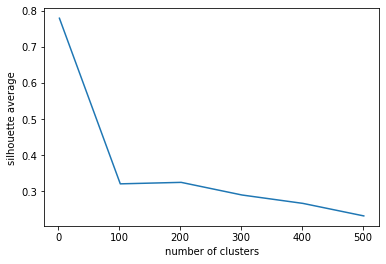

In [45]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=600 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [46]:
number_of_clusters =  100
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 96     1
84     1
35     1
88     1
15     2
24     2
48     2
62     2
61     2
92     2
74     3
95     3
93     3
7      3
86     3
47     3
99     3
73     3
69     3
44     3
55     3
83     3
97     4
90     4
87     4
12     4
68     4
58     4
66     4
63     4
98     4
56     4
36     4
54     4
30     5
28     5
13     5
8      5
57     5
50     5
51     5
64     5
43     5
49     5
85     6
40     6
82     6
67     6
65     6
20     6
2      6
91     6
38     6
45     7
81     7
18     7
59     7
77     7
94     7
34     7
71     8
10     8
3      8
29     8
4      8
80     8
31     8
16     8
72     9
52     9
42     9
19     9
22     9
23     9
60     9
39     9
27    10
41    10
6     10
79    10
0     10
21    11
76    12
37    12
5     12
32    13
78    13
89    13
26    13
75    14
9     15
33    16
25    17
14    17
11    19
46    19
53    20
70    20
17    26
1     48
Name: label_kmedoids, dtype: int64


In [47]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [49]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

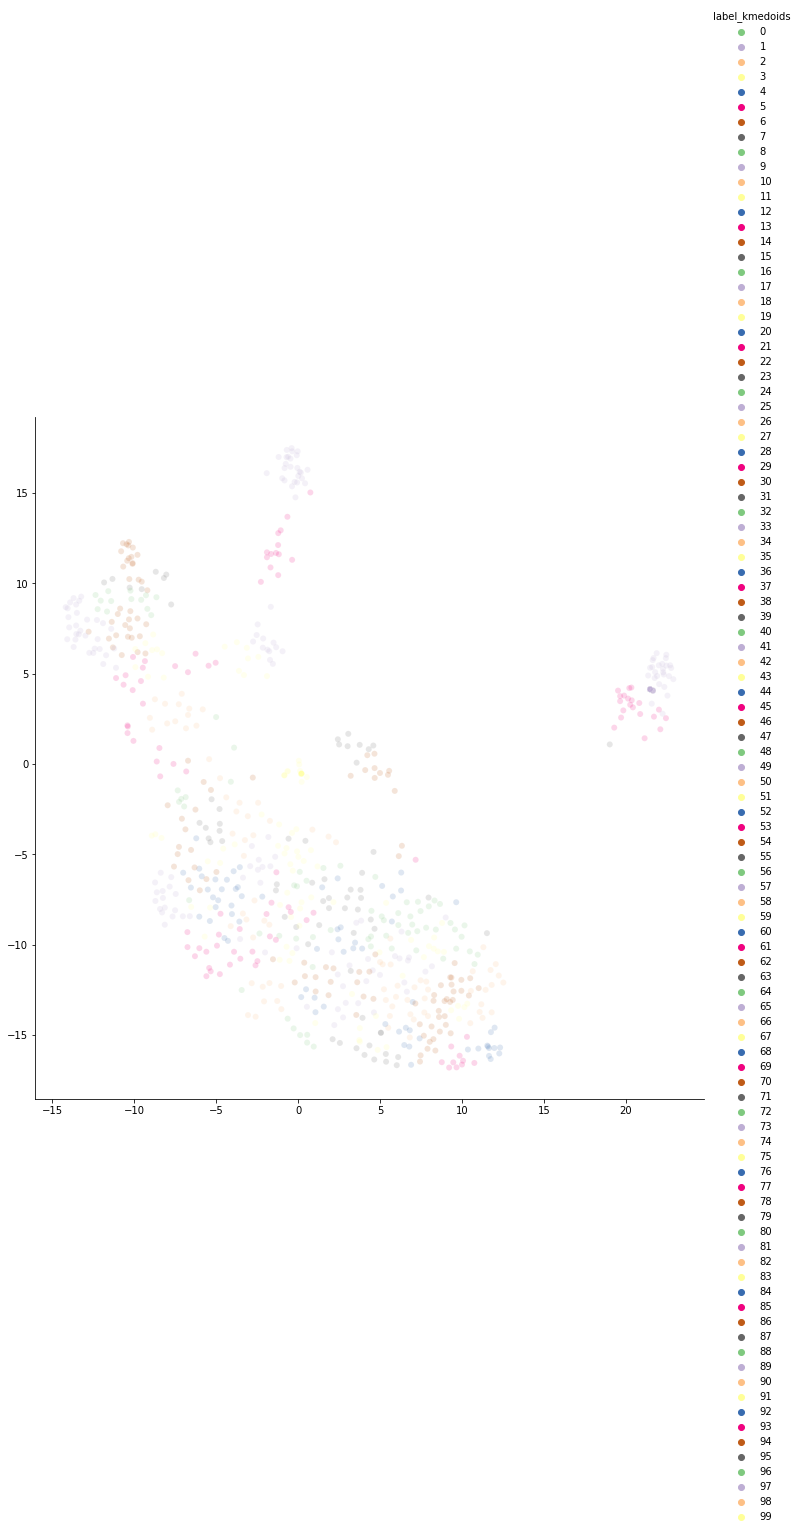

In [50]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

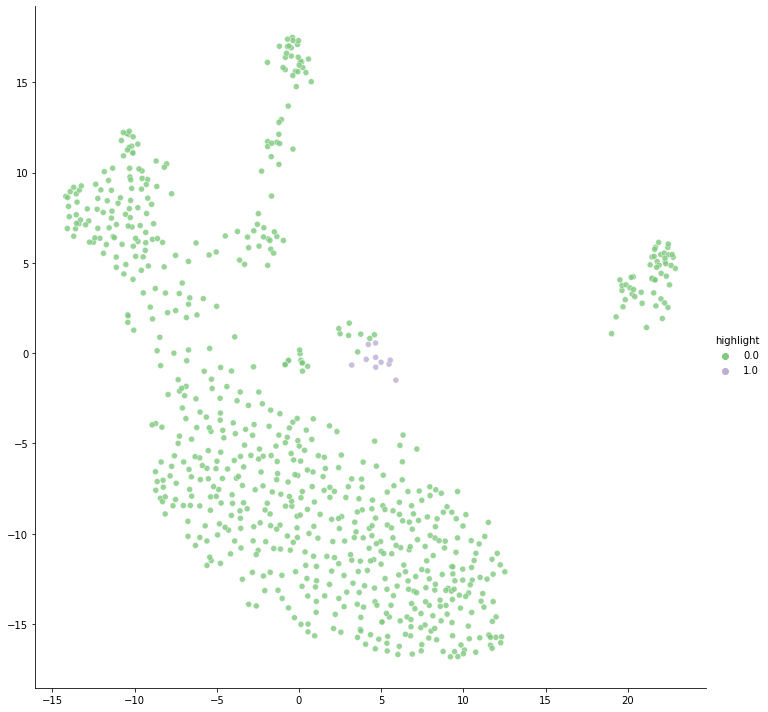

In [51]:
## Choose a cluster to higlight:
cluster_num = 6

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [52]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
296,2020-10-27 22:40:15,Wolfgang Hary,Die Pöbelei im Hintergrund sagt alles .,0,Die Pöbelei im Hintergrund sagt alles .\n\n,-1.0,0,0.000000e+00,0.0
344,2020-10-27 19:52:52,Retter der Meinungsfreiheit,Göttlich!!,0,Göttlich!!\n\n,-1.0,1,0.000000e+00,0.0
499,2020-11-01 17:49:48,Androlan01,"​@J M Ich habe nicht Trump mit Hitler verglichen sondern versucht, Ihre Aussage ein wenig realistischer zu gestalten. Zitat: ""Was glaubst du wohl, wie Hitler so stark werden konnte? Mit genau der gleichen Art und Weise, wie die Menschen heute alles glauben, was die Regierung sagt."" Und Ihr Vergleich zeugt dann von Intelligenz. Und zum Schluss natürlich die obligatorische ÖR-Klatsche und sich selber dann über die Nazikeule beschweren. Ja ne, is kla. Danke. Reicht schon. Tschüs.",1,"​@J M Ich habe nicht Trump mit Hitler verglichen sondern versucht, Ihre\nAussage ein wenig realistischer zu gestalten. Zitat: ""Was glaubst du wohl, wie\nHitler so stark werden konnte? Mit genau der gleichen Art und Weise, wie die\nMenschen heute alles glauben, was die Regierung sagt."" Und Ihr Vergleich zeugt\ndann von Intelligenz. Und zum Schluss natürlich die obligatorische ÖR-Klatsche\nund sich selber dann über die Nazikeule beschweren. Ja ne, is kla. Danke.\nReicht schon. Tschüs.\n\n",-1.0,2,0.000000e+00,0.0
655,2020-10-27 19:04:34,Drei Stein,"Nein da muss ich wiedersprechen, es geht ums Geld. Co2 Zertifikate, die Milliarden für die Windindustrie die wir über den Strompreis zahlen und ab 1. Januar kommen für Hr, Scholz pro Liter Benzin, Diesel und Heizöl 7 Cent zusätzliche Steuern oben drauf. Das alles trotz Energiesteuer (Ökosteuer) MwSt. wo sich der Staat schon Milliarden einsteckt. Hierdurch werden auch andere Produkte teurer da der Transport und die Heizung auch teurer werden.",1,"Nein da muss ich wiedersprechen, es geht ums Geld. Co2 Zertifikate, die\nMilliarden für die Windindustrie die wir über den Strompreis zahlen und ab 1.\nJanuar kommen für Hr, Scholz pro Liter Benzin, Diesel und Heizöl 7 Cent\nzusätzliche Steuern oben drauf. Das alles trotz Energiesteuer (Ökosteuer)\nMwSt. wo sich der Staat schon Milliarden einsteckt. Hierdurch werden auch\nandere Produkte teurer da der Transport und die Heizung auch teurer werden.\n\n",-1.0,3,0.000000e+00,0.0
475,2020-10-27 18:49:44,In somnia,"@Ex Urban Über seine Art kann man geteilter Meinung sein, das kann ich sogar nachvollziehen. Er macht das aber nicht, weil er glaubt mehr zu wissen, sondern weil er genau weiß, dass die genannten Statistiken durchaus bekannt aber wissentlich ignoriert werden. Ich habe Wissenschaftler schon bis aufs Ärgste streiten sehen über dieses Thema. Und das fehlt total. Der Streit, die Abwägung, das Aushandeln, die Abstimmungen.",1,"@ Über seine Art kann man geteilter Meinung sein, das kann ich sogar\nnachvollziehen. Er macht das aber nicht, weil er glaubt mehr zu wissen,\nsondern weil er genau weiß, dass die genannten Statistiken durchaus bekannt\naber wissentlich ignoriert werden. Ich habe Wissenschaftler schon bis aufs\nÄrgste streiten sehen über dieses Thema. Und das fehlt total. Der Streit, die\nAbwägung, das Aushandeln, die Abstimmungen.\n\n",-1.0,4,0.000000e+00,0.0
580,2020-11-10 13:15:02,SATIRE FOR ALL,"@Jonas Das war von Anfang an klar das du verloren hast, schließlich hast du nicht ein Argument bzw. einen Beleg gebracht für deine Aussagen. Im Gegensatz dazu wurden dir etliche Quellen verlinkt die aufzeigen was der IPCC tatsächlich ist und macht, also eine politisch gegründete Organisation die alle Gegenteiligen Ergebnisse und Modelle anderer Wissenschaftler einfach ungeprüft zensieren bzw gar nicht erst zulassen. Eigenartigerweise wurden solche Dinge noch vor 13 Jahren von unseren Medien aufgedeckt und kritisiert, heute agieren sie wie der IPCC selbst und hinterfragen nicht sondern veröffentlichen nur die ""Ergebnisse"" des IPCC und diffamieren alle die anderes Aussagen als ""L

In [53]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  10 mean distance from center:  0.0011152029401273467 Proportion of replies: 20.0
1 number of samples:  48 mean distance from center:  0.0003407398935451056 Proportion of replies: 62.5
2 number of samples:  6 mean distance from center:  0.0004112720489501953 Proportion of replies: 83.33333333333333
3 number of samples:  8 mean distance from center:  0.0010848045349121094 Proportion of replies: 62.5
4 number of samples:  8 mean distance from center:  0.0011593103408813477 Proportion of replies: 75.0
5 number of samples:  12 mean distance from center:  0.0008925795555114746 Proportion of replies: 91.66666666666667
6 number of samples:  10 mean distance from center:  0.0005036592483520508 Proportion of replies: 10.0
7 number of samples:  3 mean distance from center:  0.00047087669372558594 Proportion of replies: 0.0
8 number of samples:  5 mean distance from center:  0.0017344951629638672 Proportion of replies: 60.0
9 number of samples:  15 mean distance from center: 

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [59]:
# Choose a cluster to print
cluster_number =   21
# Choose the number of samples to print
number_of_samples_to_print = 10000

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 11
Average Distance from cluster center: 7.949091923364904e-06


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
4,2020-11-19 08:39:25,Paul Leitner,Sehr sehr schöne Rede :D,0,Sehr sehr schöne Rede :D\n\n,-1.0,21,0.000000e+00,0.0
405,2020-10-27 17:23:11,Bammser Bammser,Sehr gute Rede !!!! 100000 liks 👍,0,Sehr gute Rede !!!! 100000 liks 👍\n\n,-1.0,21,7.748604e-07,0.0
358,2020-10-27 18:54:56,Sylvester 66,Gute Rede.. 👍,0,Gute Rede.. 👍\n\n,-1.0,21,2.205372e-06,0.0
124,2020-10-30 00:03:58,Joachim Wohlers,Sehr gute Rede. Mein Respekt.,0,Sehr gute Rede. Mein Respekt.\n\n,-1.0,21,2.801418e-06,0.0
141,2020-10-29 17:06:28,Pan Tau,"Wwouuuu was für eine gute rede,nur noch AFD",0,"Wwouuuu was für eine gute rede,nur noch AFD\n\n",-1.0,21,2.801418e-06,0.0
166,2020-10-29 11:25:15,Löwe,SEHR GUTE Rede! DANKE SEHR!,0,SEHR GUTE Rede! DANKE SEHR!\n\n,-1.0,21,3.635883e-06,0.0
540,2020-10-29 17:32:40,David Alexander Forde,"Danke schön, Heiko Schrang!",1,"Danke schön, Heiko Schrang!\n\n",-1.0,21,6.318092e-06,0.0
214,2020-10-28 15:12:34,V,Hallo Neandertaler haben auch gepupt ... Klimaneutral zZzz,0,Hallo Neandertaler haben auch gepupt ... Klimaneutral zZzz\n\n,-1.0,21,1.305342e-05,0.0
29,2020-11-09 08:29:43,Ramona Licht,Ihr habt mein Like und Abo!,0,Ihr habt mein Like und Abo!\n\n,-1.0,21,1.341105e-05,0.0
743,2020-10-27 15:09:35,Jörg Festersen,Hammer Rede und inhaltlich sehr gut dargestellt.,0,Hammer Rede und inhaltlich sehr gut dargestellt.\n\n,-1.0,21,1.704693e-05,0.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [64]:
#which cluster would you like to assign labels to?
cluster_number = 0
#your label
label_manual = 'die dummen anderen'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [65]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
296,2020-10-27 22:40:15,Wolfgang Hary,Die Pöbelei im Hintergrund sagt alles .,0,Die Pöbelei im Hintergrund sagt alles .\n\n,die dummen anderen,0,0.000000,0.0
429,2020-10-27 16:42:44,Michal Murawski,Das werden die nie kapieren 😂,0,Das werden die nie kapieren 😂\n\n,die dummen anderen,0,0.000007,0.0
426,2020-10-27 18:50:15,Gisela H.,Die verblödeten Leute hindern den Vortschritt.....,1,Die verblödeten Leute hindern den Vortschritt.....\n\n,die dummen anderen,0,0.000007,0.0
144,2020-10-29 16:33:20,Brigitte Wagner,"Super Rede,das brauchen die roten Socken",0,"Super Rede,das brauchen die roten Socken\n\n",die dummen anderen,0,0.000009,0.0
766,2020-10-28 13:49:08,Marco P,Die erkennen auf den Diagrammen höchstens die Farben Orange und Blau!,1,Die erkennen auf den Diagrammen höchstens die Farben Orange und Blau!\n\n,die dummen anderen,0,0.000009,0.0
317,2020-10-27 20:56:33,Norbert Fleck,Die Entwaldung des Planeten ist das heutige Hauptproblem.,0,Die Entwaldung des Planeten ist das heutige Hauptproblem.\n\n,die dummen anderen,0,0.000011,0.0
50,2020-11-03 16:37:20,Freddy Wolf,Und im Hintergrund die völlig verdummten grün roten Brüllaffen,0,Und im Hintergrund die völlig verdummten grün roten Brüllaffen\n\n,die dummen anderen,0,0.000011,0.0
512,2020-10-27 15:47:37,TheHirade,Die wurden schön vorgeführt 👍,0,Die wurden schön vorgeführt 👍\n\n,die dummen anderen,0,0.000017,0.0
113,2020-10-31 07:30:58,Rüdiger Weissmann,Die Römer und Gernanen mit ihren Panzern damals,0,Die Römer und Gernanen mit ihren Panzern damals\n\n,die dummen anderen,0,0.000019,0.0
300,2020-10-27 22:35:07,Karl Gronauer,"Wärme war nie das Problem, die Kälte hat immer Unglück gebtacht.",0,"Wärme war nie das Problem, die Kälte hat immer Unglück gebtacht.\n\n",die dummen anderen,0,0.000022,0.0
